In [1]:
######################################################
#################### IMPORTS
######################################################
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import os
import warnings
import seaborn as sns
import re
import string
from termcolor import colored
from nltk import word_tokenize
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')
from matplotlib.pyplot import *

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfTransformer
######################################################
#################### Globals
######################################################

seed = 12345
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
encoder = preprocessing.LabelEncoder()

######################################################
#################### Helper Functions
######################################################
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess(text):

    # lowercase the text
    text = text.lower()
    # remove the words counting just one letter
    text = [t for t in text.split(" ") if len(t) > 1]

    # remove the words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # tokenize the text and remove puncutation

    text = [word.strip(string.punctuation) for word in text]
    # remove all stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove tokens that are empty
    text = [t for t in text if len(t) > 0]
    # pos tag the text
    pos_tags = pos_tag(text)
    # lemmatize the text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    # join all
    text = " ".join(text)
    return (text)

def split_train_holdout_test(encoder, df, verbose=True):
  # Resplit original train and test
  train = df[df["label"] != "None"]
  test = df[df["label"] == "None"]

  # Encode Target
  train["encoded_label"] = encoder.fit_transform(train.label.values)

  # Take holdout from train
  train_cv, train_holdout, train_cv_label, train_holdout_label = train_test_split(train, train.encoded_label, test_size=0.33, random_state=seed)

  if(verbose):
    print("\nTrain dataset (Full)")
    print(train.shape)
    print("Train dataset cols")
    print(list(train.columns))

    print("\nTrain CV dataset (subset)")
    print(train_cv.shape)
    print("Train Holdout dataset (subset)")
    print(train_holdout.shape)

    print("\nTest dataset")
    print(test.shape)
    print("Test dataset cols")
    print(list(test.columns))

  return encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label

def runModel(encoder, train_vector, train_label, holdout_vector, holdout_label, type, name):
  global cv
  global seed

  ## Classifier types
  if (type == "svc"):
    classifier = SVC()
    grid = [
      {'C': [1, 10, 50, 100], 'kernel': ['linear']},
      {'C': [10, 100, 500, 1000], 'gamma': [0.0001], 'kernel': ['rbf']},
    ]
  if (type == "nb"):
    classifier = MultinomialNB()
    grid = {}
  if (type == "maxEnt"):
      classifier = LogisticRegression()
      grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

  # Model
  print(colored(name, 'red'))

  model = GridSearchCV(estimator=classifier, cv=cv,  param_grid=grid)
  print(colored(model.fit(train_vector, train_label), "yellow"))

  # Score
  print(colored("\nCV-scores", 'blue'))
  means = model.cv_results_['mean_test_score']
  stds = model.cv_results_['std_test_score']
  for mean, std, params in sorted(zip(means, stds, model.cv_results_['params']), key=lambda x: -x[0]):
      print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
  print()


  print(colored("\nBest Estimator Params", 'blue'))
  print(colored(model.best_estimator_, "yellow"))

  # Predictions
  print(colored("\nPredictions:", 'blue'))
  model_train_pred = encoder.inverse_transform( model.predict(holdout_vector) )
  print(model_train_pred)

  # Confusion Matrix
  cm = confusion_matrix(holdout_label, model_train_pred)

  # Transform to df for easier plotting
  cm_df = pd.DataFrame(cm,
                      index = ['FAKE','REAL'],
                      columns = ['FAKE','REAL'])


  plt.figure(figsize=(5.5,4))
  sns.heatmap(cm_df, annot=True, fmt='g')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  # Accuracy
  acc = accuracy_score(holdout_label, model_train_pred)
  print(colored("\nAccuracy:", 'blue'))
  print(colored(acc, 'green'))
  return [name, model, acc]

def pos_tag_words(text):
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    return " ".join([pos + "-" + word for word, pos in pos_text])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Venu Priya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
input_str = open(r"fake_or_real_news_training.csv", encoding= 'utf-8')

# Remove all new lines
noNewLines = re.sub("\n", "", input_str.read())
# re-add new line at end of each row
noNewLines = re.sub("X1,X2", "X1,X2\n", noNewLines)
noNewLines = re.sub(",FAKE[,]+", ",FAKE,,\n", noNewLines)
# noNewLines = re.sub(",FAKE,(?!,)",",FAKE,,\n",noNewLines)
# noNewLines = re.sub(",FAKE,,(?!,)",",FAKE,,\n",noNewLines)
  
noNewLines = re.sub(",REAL[,]+", ",REAL,,\n", noNewLines)
# noNewLines = re.sub(",REAL,(?!,)",",REAL,,\n",noNewLines)
# noNewLines = re.sub(",REAL,,(?!,)",",REAL,,\n",noNewLines)
# Replace any commas between two quotes with |
lines = noNewLines.split('\n')
def removeComma(g):
      t = g.groups()
      t = [t[0], t[1].replace(',', ' |'), t[2], t[3]]
      return "".join(t)
betweenQuotes = lambda line: re.sub(r'(.*,")(.*)(",)(.*)', lambda x: removeComma(x), line)
secondCol = lambda line: re.sub(r'^([0-9]+,)(.*,.*)(,\")(.*)$', lambda x: removeComma(x), line, 1)
lines = [betweenQuotes(l) for l in lines]
lines = [secondCol(l) for l in lines]
finalString = '\n'.join(lines)

In [3]:
file = open('fake_or_real_news_training_CLEANED.csv', 'w',encoding= 'utf-8')
file.write(finalString)
file.close()

In [4]:
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")
test = pd.read_csv("fake_or_real_news_test.csv")
train = train.drop(['X1', 'X2'], axis=1)

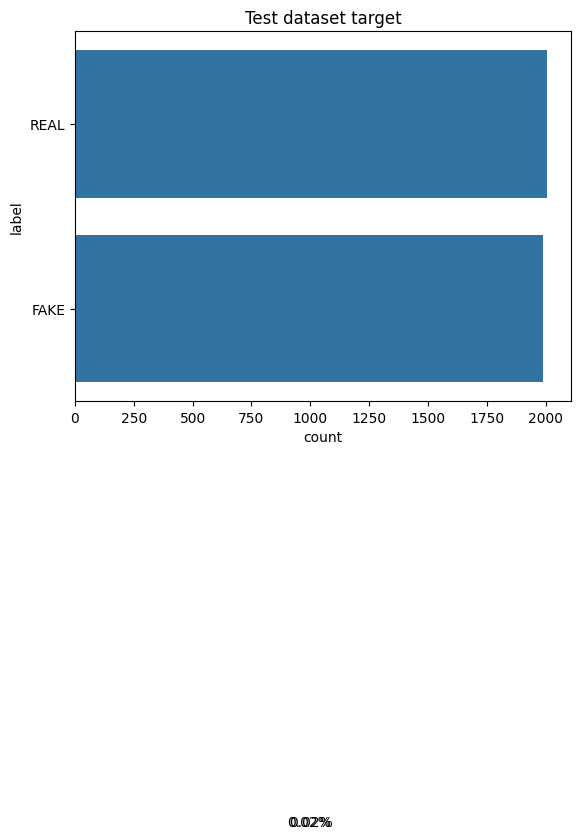

In [5]:
from collections import Counter
ax = sns.countplot(train.label, order=[x for x, count in sorted(Counter(train.label).items(), key=lambda x: -x[1])])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center") 
ax.set_title("Test dataset target")
show()

In [6]:
test['label'] = None  # empty label for test
df = pd.concat([train, test])

In [7]:
df['title_and_text'] = df['title'] +' '+ df['text']
df.tail()

,ID,title,text,label,title_and_text
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se..."
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...


In [9]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))
## Save preprocessed df
df.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)
df = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
df = df.astype(object).replace(np.nan, 'None')
df.tail()

,ID,title,text,label,title_and_text,preprocessed_text
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...
6317,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...,jeb bush suddenly attack trump here's matter j...


In [10]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df)


Train dataset (Full)
(3997, 7)
Train dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text', 'encoded_label']

Train CV dataset (subset)
(2677, 7)
Train Holdout dataset (subset)
(1320, 7)

Test dataset
(2321, 6)
Test dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text']


In [11]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))
## Save preprocessed df
df.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)
df = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
df = df.astype(object).replace(np.nan, 'None')
df.tail()

,ID,title,text,label,title_and_text,preprocessed_text
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...
6317,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...,jeb bush suddenly attack trump here's matter j...


In [12]:
models = pd.DataFrame(columns=['model_name', 'model_object', 'score'])

In [13]:
count_vect = CountVectorizer(analyzer = "word")
count_vectorizer = count_vect.fit(df.preprocessed_text)
train_cv_vector = count_vectorizer.transform(train_cv.preprocessed_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.preprocessed_text)
test_vector = count_vectorizer.transform(test.preprocessed_text)
count_vect.get_feature_names_out()[:10]

array(['___', '_blank', '_derosa', '_rt_op_edge', '_strauss', 'aa', 'aaa',
       'aaahhh', 'aab', 'aachen'], dtype=object)

Baseline Model 1: SVC
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.909 (+/-0.022) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.902 (+/-0.030) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.893 (+/-0.030) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.886 (+/-0.011) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=100, gamma

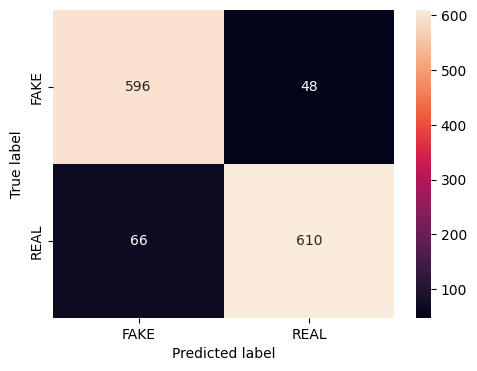


Accuracy:
0.9136363636363637


In [14]:
SVC_classifier = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "Baseline Model 1: SVC")
models.loc[len(models)] = SVC

Baseline Model 2: Naiive Bayes
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.887 (+/-0.021) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


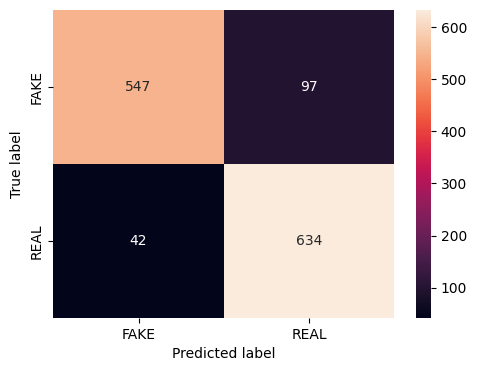


Accuracy:
0.8946969696969697


In [15]:
NB = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Baseline Model 2: Naiive Bayes")
models.loc[len(models)] = NB

Baseline Model 3: MaxEnt Classifier
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.877 (+/-0.023) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.913 (+/-0.012) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.929 (+/-0.012) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.924 (+/-0.019) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.922 (+/-0.025) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100,

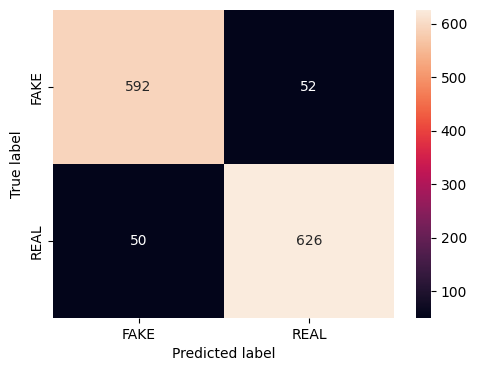


Accuracy:
0.9227272727272727


In [16]:
maxEnt = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "Baseline Model 3: MaxEnt Classifier")
models.loc[len(models)] = maxEnt

In [17]:
df['pos_tagged_text'] = df['preprocessed_text'].apply(lambda x: pos_tag_words(x))
df.head()

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...


In [18]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)
count_vect = CountVectorizer(analyzer = "word")
count_vectorizer = count_vect.fit(df.preprocessed_text)
train_cv_vector = count_vectorizer.transform(train_cv.pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.pos_tagged_text)
test_vector = count_vectorizer.transform(test.pos_tagged_text)

SVC on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.921 (+/-0.025) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.914 (+/-0.020) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.028) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.022) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 100, 'kernel': 'linear'}


Best Estimator Params
SVC(C=100, gamm

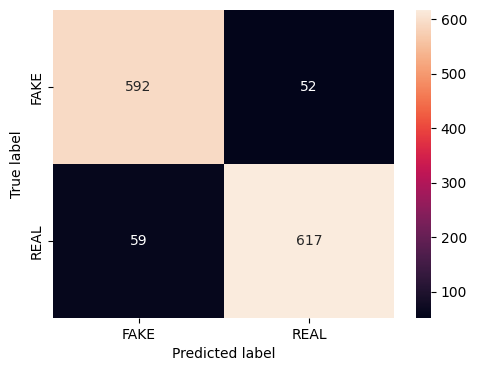


Accuracy:
0.9159090909090909


In [19]:
SVC_pos_tag = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "SVC on pos-tagged text")
models.loc[len(models)] = SVC_pos_tag

Naiive Bayes on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.889 (+/-0.017) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


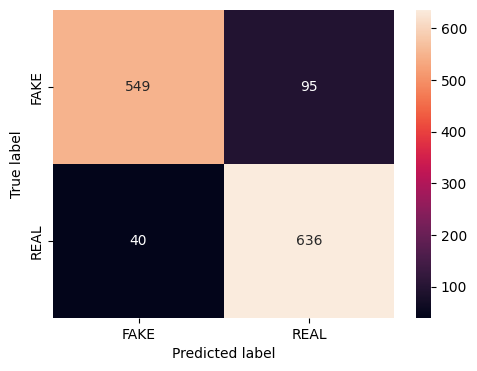


Accuracy:
0.8977272727272727


In [20]:
NB_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Naiive Bayes on pos-tagged text")
models.loc[len(models)] = NB_pos_tag

MaxEnt Classifier on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.885 (+/-0.013) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.918 (+/-0.017) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.930 (+/-0.026) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.027) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.932 (+/-0.033) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100

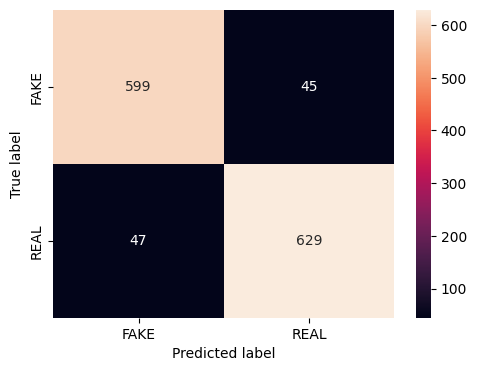


Accuracy:
0.9303030303030303


In [21]:
maxEnt_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "MaxEnt Classifier on pos-tagged text")
models.loc[len(models)] = maxEnt_pos_tag

In [22]:
df["clean_and_pos_tagged_text"] = df['preprocessed_text'] + ' ' + df['pos_tagged_text']
df.head(1)

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...


In [23]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)
count_vect = CountVectorizer(analyzer = "word")
count_vectorizer = count_vect.fit(df.clean_and_pos_tagged_text)
train_cv_vector = count_vectorizer.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = count_vectorizer.transform(test.clean_and_pos_tagged_text)
tf_idf = TfidfTransformer(norm="l2")
train_cv_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_tf_idf = tf_idf.fit_transform(test_vector)  

SVC on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Est

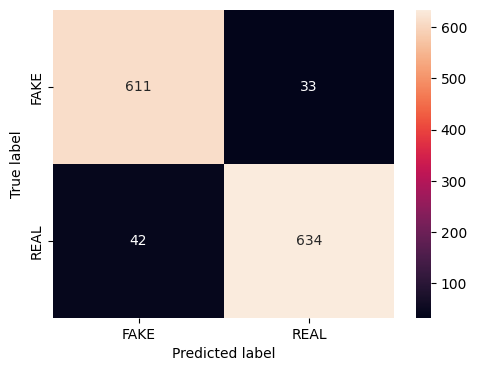


Accuracy:
0.9431818181818182


In [24]:
SVC_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = SVC_tf_idf

Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.781 (+/-0.039) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


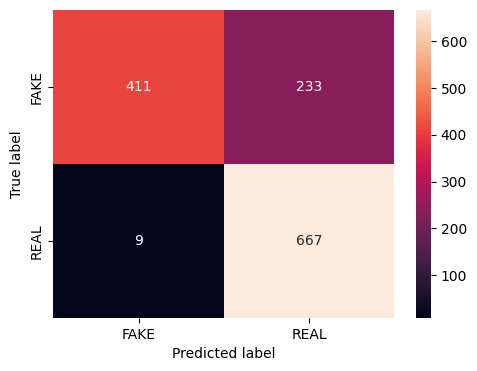


Accuracy:
0.8166666666666667


In [25]:
NB_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "nb",
              "Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = NB_tf_idf

MaxEnt on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.553 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.024) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.906 (+/-0.006) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.933 (+/-0.020) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for

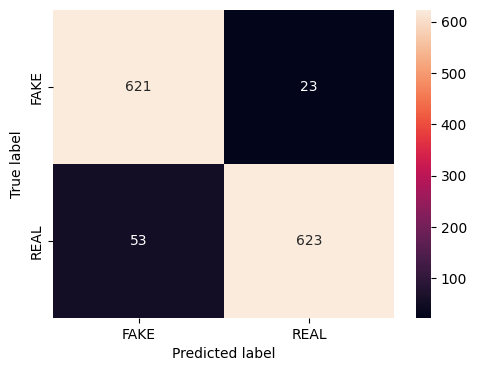


Accuracy:
0.9424242424242424


In [26]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = maxEnt_tf_idf

In [27]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)
trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2))
trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)
train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = trigram_vect.transform(test.clean_and_pos_tagged_text)

tf_idf = TfidfTransformer(norm="l2")
train_cv_bigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_bigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_bigram_tf_idf = tf_idf.fit_transform(test_vector)

SVC on bigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=10, 

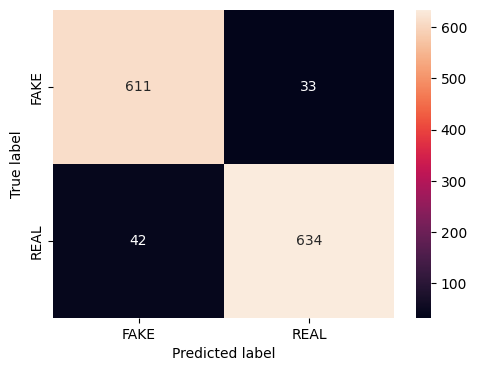


Accuracy:
0.9431818181818182


In [28]:
SVC_trigram_tf_idf = runModel(encoder,
               train_cv_bigram_tf_idf,
               train_cv_label,
               train_holdout_bigram_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on bigram vect.+ TF-IDF")
models.loc[len(models)] = SVC_trigram_tf_idf

In [29]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)
trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3))
trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)
train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)

tf_idf = TfidfTransformer(norm="l2")
train_cv_trigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_trigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)

MaxEnt on trigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.553 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.024) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.906 (+/-0.006) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.933 (+/-0.020) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100, 'pe

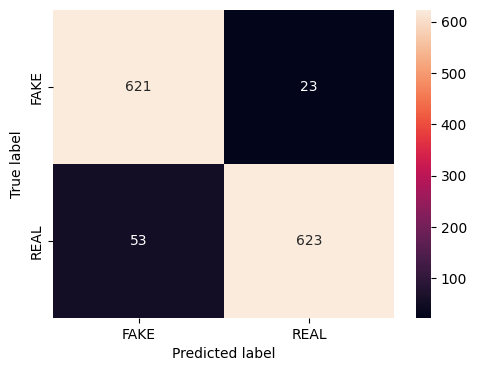


Accuracy:
0.9424242424242424


In [30]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_trigram_tf_idf,
               train_cv_label,
               train_holdout_trigram_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on trigram vect.+ TF-IDF")
models.loc[len(models)] = maxEnt_tf_idf

In [31]:
test = pd.read_csv("fake_or_real_news_test.csv")
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")

train['title_and_text'] = train['title'] +' '+ train['text']
train['preprocessed_text'] = train['title_and_text'].apply(lambda x: preprocess(x))

test['title_and_text'] = test['title'] +' '+ test['text']
test['preprocessed_text'] = test['title_and_text'].apply(lambda x: preprocess(x))

## Save preprocessed df
train.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

# Save preprocessed df
test.to_csv("fake_or_real_news_test_PREPROCESSED.csv", index=False)

In [32]:
train = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
train = train.astype(object).replace(np.nan, 'None')

test = pd.read_csv("fake_or_real_news_test_PREPROCESSED.csv")
test = test.astype(object).replace(np.nan, 'None')

In [33]:
train['pos_tagged_text'] = train['preprocessed_text'].apply(lambda x: pos_tag_words(x))
test['pos_tagged_text'] = test['preprocessed_text'].apply(lambda x: pos_tag_words(x))

In [34]:
train["clean_and_pos_tagged_text"] = train['preprocessed_text'] + ' ' + train['pos_tagged_text']
test["clean_and_pos_tagged_text"] = test['preprocessed_text'] + ' ' + train['pos_tagged_text']

In [35]:
from sklearn.pipeline import Pipeline
trigram_vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,3))
tf_idf = TfidfTransformer(norm="l2")
classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

pipeline = Pipeline([
     ('trigram_vectorizer', trigram_vectorizer),
     ('tfidf', tf_idf),
     ('clf', classifier),
 ])

In [36]:
pipeline.fit(train.clean_and_pos_tagged_text, encoder.fit_transform(train.label.values))

Pipeline(steps=[('trigram_vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, multi_class='multinomial',
                                    solver='saga'))])

In [37]:
import pickle
pickle.dump( pipeline, open( "pipeline.pkl", "wb" ) )

In [38]:
print(colored("Predicting on test", 'blue'))
test_predictions = test_predictions = pipeline.predict(test.clean_and_pos_tagged_text)
test_predictions_decoded = encoder.inverse_transform( test_predictions )

predictions = test
predictions["label"] = test_predictions_decoded

Predicting on test


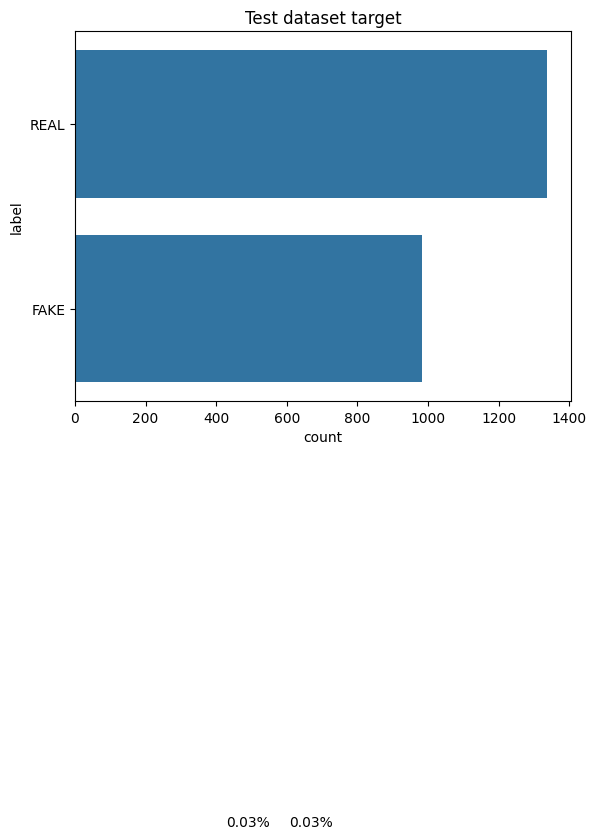

In [39]:
import collections
ax = sns.countplot(predictions.label,
                order=[x for x, count in sorted(collections.Counter(predictions.label).items(),
                key=lambda x: -x[1])])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(predictions)*100),
            ha="center") 
ax.set_title("Test dataset target")
show()

In [40]:
predictions.drop(columns=["title","text","title_and_text","preprocessed_text","pos_tagged_text","clean_and_pos_tagged_text"]).head()

,ID,label
0,10498,FAKE
1,2439,FAKE
2,864,REAL
3,4128,REAL
4,662,REAL


In [42]:
predictions.to_csv("TEST_PREDICTIONS-1.csv", index=False)